## Импорт необходимых библиотек

In [ ]:
!pip install tweet-preprocessor gensim kaggle scikit-learn

In [2]:
import pandas as pd
import preprocessor as p
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
import gensim
from sklearn.model_selection import train_test_split
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

## Анализ данных

In [3]:
api = KaggleApi()
api.authenticate()
api.dataset_download_files('kazanova/sentiment140')

In [4]:
with zipfile.ZipFile('sentiment140.zip', 'r') as zipref:
    zipref.extractall('sentiment140/')

In [5]:
colnames=['target', 'ids', 'date', 'flag', 'user', 'text']
data = pd.read_csv("sentiment140/training.1600000.processed.noemoticon.csv", encoding='cp1252', names=colnames, header=None)
data.sample(10)

,target,ids,date,flag,user,text
1264139,4,1999180478,Mon Jun 01 19:46:44 PDT 2009,NO_QUERY,likezerogravity,@DavidArchie I didn't know you could play soft...
327442,0,2009602990,Tue Jun 02 15:58:19 PDT 2009,NO_QUERY,itzleebishes,I wish I had a female friend that I could goss...
771138,0,2302251743,Tue Jun 23 16:32:52 PDT 2009,NO_QUERY,elizabethdehoff,Thinking about dropping by @JugShop for tonigh...
529209,0,2195375692,Tue Jun 16 11:02:50 PDT 2009,NO_QUERY,noudles04,@momAgenda Why do all the momAgenda's start in...
742975,0,2266704568,Sun Jun 21 08:57:55 PDT 2009,NO_QUERY,GinaIsWizard,boredddd.... its the longest day o the year to...
753052,0,2286749440,Mon Jun 22 16:52:24 PDT 2009,NO_QUERY,choosly,@wonkette Actually it killed 4
815987,4,1551301352,Sat Apr 18 08:41:28 PDT 2009,NO_QUERY,ScrapShoppeEtsy,@PaperCakes have a great party! send us some ...
651240,0,2237826490,Fri Jun 19 06:25:11 PDT 2009,NO_QUERY,CGTEMPE,Ahh my croissant tastes so good from Christies...
1005831,4,1880551162,Fri May 22 01:38:51 PDT 2009,NO_QUERY,rjohanningmeier,@Bhinshaw So do I. The next 4 days are going t...
327962,0,2010170718,Tue Jun 02 16:55:58 PDT 2009,NO_QUERY,rakaur,Just now leaving work - http://bkite.com/086Vt


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
data.drop(['ids', 'date', 'flag', 'user'], axis=1, inplace=True)
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


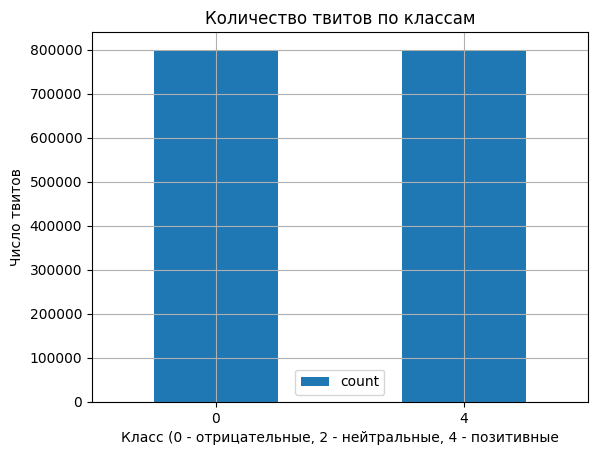

In [8]:
data['target'].value_counts().plot(
    kind='bar',
    rot=0,
    title='Количество твитов по классам',
    xlabel='Класс (0 - отрицательные, 2 - нейтральные, 4 - позитивные',
    ylabel='Число твитов',
    legend=True,
    grid=True
);

Класса получается всего 2, поэтому мы будем делать бинарную классификацию. Заменим метку класса 4 на 1:

In [9]:
data['target'] = data['target'].replace(4,1)

## Предобработка данных

In [10]:
print(STOPWORDS)

frozenset({'down', 'forty', 'whether', 'now', 'not', 'beforehand', 'seems', 'there', 'him', 'didn', 'anyway', 'ltd', 'upon', 'beside', 'etc', 'eleven', 'part', 'almost', 'hereafter', 'somehow', 'sometime', 'another', 'their', 'he', 'quite', 'whom', 'else', 'three', 'whose', 'few', 'found', 'enough', 'one', 'cry', 'without', 'two', 'her', 'too', 'please', 'fifty', 'de', 'six', 'every', 'among', 'more', 'fire', 'empty', 'seemed', 'together', 'ourselves', 'because', 'did', 'amount', 'on', 'used', 'call', 'such', 'several', 'ie', 'do', 'doesn', 'over', 'detail', 'whereupon', 'hence', 'it', 'interest', 'nine', 'me', 'seem', 'but', 'they', 'myself', 'whereafter', 'km', 'behind', 'by', 'into', 'hereupon', 'though', 'twelve', 'really', 'ten', 'will', 'across', 'computer', 'whatever', 'might', 'only', 'she', 'can', 'why', 'however', 'anywhere', 'just', 'have', 'how', 'name', 'get', 'whenever', 'the', 'alone', 'or', 'during', 'nowhere', 'ours', 'a', 'often', 'yet', 'these', 'out', 'hasnt', 'neit

Данные стоп слова вряд ли влияют на настроение твита, так что возьму их прямо из коробки.

In [11]:
%%time
def preprocess_tweet(row):
    text = row['text']
    text = p.clean(text)
    text = remove_stopwords(text)
    return text.lower().replace('\s\s+', ' ')

data['cleaned_text'] = data.apply(preprocess_tweet, axis=1)

CPU times: total: 2min 57s
Wall time: 3min 1s


In [12]:
data.sample(10)

,target,text,cleaned_text
1315538,1,Me and my friends are playing UrbanTerror a lo...,me friends playing urbanterror lot days... it'...
268564,0,outta credit to txt ppl,outta credit txt ppl
1527402,1,@lendenpen awww kyooot. now i like him even mo...,awww kyooot. like more!! hahaha
698141,0,my jeans are still in the dryer which means I'...,jeans dryer means i'll wearing heals casual da...
501426,0,@missy_gee i Dont. Well kinda. I can check som...,dont. well kinda. i check stuff fb phone! i wa...
219433,0,I hope that these kitchen renos don't last any...,i hope kitchen renos don't longer... annoying
718943,0,these fireworks are lame.,fireworks lame.
1483184,1,@theantijared hahaha you crack me up,hahaha crack
1239313,1,Reading New Moon!! i just love it!! Edwart mar...,reading new moon!! love it!! edwart marry me!!
542079,0,"sorry, Taylor! cmt wont come up on my psp's br...","sorry, taylor! cmt wont come psp's browser!"


## Извлечение признаков из текста с помощью векторизации

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['target'], random_state=2023)

In [ ]:
%%time
VECTOR_SIZE = 256
model = gensim.models.FastText(
    sentences=X_train,
    vector_size=VECTOR_SIZE, # default = 100
    window=7, # default = 5
    min_count=10,
    sg=1, # Training algorithm: 1 for skip-gram; otherwise CBOW
    hs=0, #  If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
    negative=5, # If > 0, negative sampling will be used, if set to 0, no negative sampling is used.
    epochs=25, # Number of iterations (epochs) over the corpus
    seed=2023,
)